In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
events_raw = np.loadtxt(path + "data/slider-depth/events.txt")

In [43]:
start_time = 0.5
duration = 2.0
events_t = flt.filter_time(events_raw, start_time, start_time+duration)

In [44]:
events = events_t
shape = (180, 240)

In [5]:
pose_hist = np.loadtxt(path + "data/slider-depth/groundtruth.txt")

In [6]:
#TODO undistort events

In [7]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")
K = np.array([
    [calib[0], 0, calib[2]],
    [0, calib[1], calib[3]], 
    [0, 0, 1]
])

In [8]:
def get_pose(t, pose_history):
    idx = np.searchsorted(pose_hist[:,0], t)
    pose = pose_hist[idx -1 if idx > 0 else 0]
    
    t = pose[1:4].reshape(3, 1)
    q = pose[4:] 
    r = R.from_quat(q).as_matrix()
    
    return r, t

In [9]:
def get_pose_matrix(t, pose_history):
    idx = np.searchsorted(pose_hist[:,0], t)
    pose = pose_hist[idx -1 if idx > 0 else 0]
    
    t = pose[1:4].reshape(3, 1)
    q = pose[4:] 
    r = R.from_quat(q).as_matrix()
    
    p_m = np.zeros((4, 4))
    p_m[:3, :3] = r
    p_m[:3,3] = t.flatten()
    p_m[3, 3] = 1
    
    return p_m

In [10]:
# dsi_shape = (180, 240, 50)
# dsi = np.zeros(dsi_shape)
# min_depth = 0.47
# max_depth = 2.4
# n_depths = 50
# inv_depths = np.array([(1 / max_depth) + (i / (n_depths / ((1/min_depth)-(1/max_depth)))) for i in range(n_depths)])
# inv_depths = np.flip(inv_depths)
# depths = 1/inv_depths
# e3 = np.array([0,0,1]).reshape(1, 3)

# test_img = np.zeros((180, 240))

# t_w_rv = get_pose_matrix(0.0, pose_hist)
# t_rv_w = np.linalg.inv(t_w_rv)

# for e in tqdm(events):
    
#     t_w_ev = get_pose_matrix(e[0], pose_hist)
#     t_rv_ev = t_rv_w @ t_w_ev
#     t_ev_rv = np.linalg.inv(t_rv_ev)
    
#     r = t_ev_rv[:3,:3]
#     t = t_ev_rv[:3,3].reshape(3, 1)
    
#     C = - np.linalg.inv(r) @ t
#     C = np.abs(C)
#     H = K @ (r + inv_depths[0] * (t @ e3)) @ np.linalg.inv(K)
    
#     x = int(e[1])
#     y = int(e[2])
#     px = np.array([x, y, 1]).reshape(3, 1)
    
#     pxz = np.linalg.inv(H) @ px
#     pxz /= pxz[2][0]
    
#     #TODO try discrete version
#     x0 = pxz[0][0]
#     y0 = pxz[1][0]
#     z0 = depths[0]
    
#     if x0 < 0 or x0 > 239 or y0 < 0 or y0 > 179:
#         continue
    
#     #test_img[int(y0), int(x0)] = 1

#     for i, zi in enumerate(depths[1:]):
#         d = (zi - z0) / (z0 - C[2][0])
#         xi = int(z0/zi * d * x0 + 1/zi*(1-d)*C[0][0]*K[0,0])
#         yi = int(z0/zi * d * y0 + 1/zi*(1-d)*C[1][0]*K[1, 1])

#         if xi < 0 or xi > 239 or yi < 0 or yi > 179:
#             continue

#         dsi[yi, xi, int(i)] += 1
#         #test_img[yi, xi] += 1

In [11]:
# points = np.nonzero(dsi > 5)

In [12]:
# %matplotlib qt
# fig = plt.figure(figsize=(20, 20))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(points[0], points[1], points[2], s=2, c=points[2], cmap="jet_r", vmin=0.5, vmax=2.5)
# #ax.set_zlim3d([0.5, 2.5])
# #vis._set_axes_equal(ax)
# plt.show()

NameError: name 'points' is not defined

In [ ]:
# plt.imshow(test_img)

In [ ]:
# inv_depths

In [ ]:
# depths

In [ ]:
# plt.imshow(dsi[:,:,40])

In [76]:
dsi_shape = (180, 240, 50)
dsi = np.zeros(dsi_shape)
min_depth = 0.47
max_depth = 2.4
n_depths = 50
inv_depths = np.array([(1 / max_depth) + (i / (n_depths / ((1/min_depth)-(1/max_depth)))) for i in range(n_depths)])
inv_depths = np.flip(inv_depths)
depths = 1/inv_depths
e3 = np.array([0,0,1]).reshape(1, 3)

test_img = np.zeros((180, 240))

t_w_rv = get_pose_matrix(events[0,0], pose_hist)
t_rv_w = np.linalg.inv(t_w_rv)

for e in tqdm(events):
    t_w_ev = get_pose_matrix(e[0], pose_hist)
    t_rv_ev = t_rv_w @ t_w_ev
    t_ev_rv = np.linalg.inv(t_rv_ev)
    
    r = t_ev_rv[:3,:3]
    t = t_ev_rv[:3,3].reshape(3, 1)

    C = - r.transpose() @ t

    #C = np.abs(C)
    z0 = depths[0]
    H_z0_inv = r
    H_z0_inv *= z0
    H_z0_inv[:,2] += t.flatten()
    
    H_z0_inv_px = K @ H_z0_inv @ np.linalg.inv(K)
    H_z0_px = np.linalg.inv(H_z0_inv_px)
    
    x = int(e[1])
    y = int(e[2])
    px = np.array([x, y, 1]).reshape(3, 1)
    
    pxz = (H_z0_px / H_z0_px[2, 2]) @ px
#     print(H_z0_px)
#     print(pxz)
#     pxz /= pxz[2][0]
#     print(pxz)
#     print("--------")
    
    #TODO try discrete version
    x0 = int(pxz[0][0])
    y0 = int(pxz[1][0])
    z0 = depths[0]
    
    if x0 < 0 or x0 > 239 or y0 < 0 or y0 > 179:
        continue
    
    #test_img[int(y0), int(x0)] = 1

    for i, zi in enumerate(depths[1:]):
        a = z0 * (zi - C[2,0])
        bx = (z0 - zi) * (C[0, 0] * K[0,0] + C[2,0] * K[0,2])
        by = (z0 - zi) * (C[1, 0] * K[1, 1] + C[2, 0] * K[1, 2])
        d = zi * (z0 - C[2, 0])
        
#         a = int(a)
#         bx = int(bx)
#         by = int(by)
#         d = int(d)
        ad = a/d
        bxd = bx / d
        byd = by / d

        xi = int(x0 * ad + bxd)
        yi = int(y0 * ad + byd)
        
        if xi < 0 or xi > 239 or yi < 0 or yi > 179:
            continue
        dsi[yi, xi, int(i)] += 1
        #test_img[yi, xi] += 1

100%|████████████████████████████████████████████████████████████████████████| 661153/661153 [04:49<00:00, 2284.55it/s]


In [59]:
points = np.nonzero(dsi > 30)
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[0], points[1], points[2], s=2, c=points[2], cmap="jet_r", vmin=0.5, vmax=2.5)
#ax.set_zlim3d([0.5, 2.5])
#vis._set_axes_equal(ax)
plt.show()

In [60]:
plt.imshow(dsi[:,:,7])

In [45]:
sub_shape = (2, 2)
new_shape = (int(shape[0] / sub_shape[0]), int(shape[1] / sub_shape[1]))
sub_events = []
count = np.zeros(new_shape)
for e in events:
    x = int(e[1] / sub_shape[1])
    y = int(e[2] / sub_shape[0])
    
    count[y, x] += 1
    
    if count[y, x] >=2:
        sub_events.append([e[0], x, y, e[3]])
        count[y, x] = 0
        
K = np.array([
    [calib[0]/2, 0, calib[2]/2],
    [0, calib[1]/2, calib[3]/2], 
    [0, 0, 1]
])

In [46]:
sub_events = np.array(sub_events)

In [47]:
n_depths = 20
dsi_shape = (new_shape[0], new_shape[1], n_depths)
dsi = np.zeros(dsi_shape)
min_depth = 0.47
max_depth = 2.4
inv_depths = np.array([(1 / max_depth) + (i / (n_depths / ((1/min_depth)-(1/max_depth)))) for i in range(n_depths)])
inv_depths = np.flip(inv_depths)
depths = 1/inv_depths
e3 = np.array([0,0,1]).reshape(1, 3)

#test_img = np.zeros((180, 240))
bxs = []

t_w_rv = get_pose_matrix(events[0,0], pose_hist)
t_rv_w = np.linalg.inv(t_w_rv)

for e in tqdm(sub_events):
    t_w_ev = get_pose_matrix(e[0], pose_hist)
    t_rv_ev = t_rv_w @ t_w_ev
    t_ev_rv = np.linalg.inv(t_rv_ev)
    
    r = t_ev_rv[:3,:3]
    t = t_ev_rv[:3,3].reshape(3, 1)

    C = - r.transpose() @ t

    #C = np.abs(C)
    z0 = depths[0]
    H_z0_inv = r
    H_z0_inv *= z0
    H_z0_inv[:,2] += t.flatten()
    
    H_z0_inv_px = K @ H_z0_inv @ np.linalg.inv(K)
    H_z0_px = np.linalg.inv(H_z0_inv_px)
        
    x = int(e[1])
    y = int(e[2])
    px = np.array([x, y, 1]).reshape(3, 1)
    
    pxz = H_z0_px @ px
    pxz /= pxz[2][0]
    
    #TODO try discrete version
    x0 = int(pxz[0][0])
    y0 = int(pxz[1][0])
    z0 = depths[0]
    
    if x0 < 0 or x0 >= dsi_shape[1] or y0 < 0 or y0 >= dsi_shape[0]:
        continue
    
    #test_img[int(y0), int(x0)] = 1

    for i, zi in enumerate(depths[1:]):
        a = z0 * (zi - C[2,0])
        bx = (z0 - zi) * (C[0, 0] * K[0,0] + C[2,0] * K[0,2])
        by = (z0 - zi) * (C[1, 0] * K[1, 1] + C[2, 0] * K[1, 2])
        d = zi * (z0 - C[2, 0])
        
        ad = a/d
        bxd = bx / d
        byd = by / d
        
        bxs.append(bxd)

        xi = int(x0 * ad + bxd)
        yi = int(y0 * ad + byd)
        
        if xi < 0 or xi >= dsi_shape[1] or yi < 0 or yi >= dsi_shape[0]:
            continue
        dsi[yi, xi, int(i)] += 1
        
        x0 = x0 * ad + bxd
        y0 = y0 * ad + byd
        z0 = zi
        #test_img[yi, xi] += 1

100%|████████████████████████████████████████████████████████████████████████| 327942/327942 [01:38<00:00, 3320.25it/s]


In [48]:
points = np.nonzero(dsi > 30)
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[0], points[1], points[2], s=2, c=points[2], cmap="jet_r", vmin=0.5, vmax=2.5)
#ax.set_zlim3d([0.5, 2.5])
#vis._set_axes_equal(ax)
plt.show()

In [49]:
plt.figure(figsize=(10, 10))
m = plt.imshow(dsi[:,:,17], interpolation="none")
#plt.colorbar(mappable=m)

In [61]:
dsi_max = dsi.max(axis=2)
dsi_max_id = np.argmax(dsi, axis=2)
dsi_max_val = depths[dsi_max_id]

In [62]:
depths[dsi_max_id]

array([[0.47768273, 0.47768273, 0.47768273, ..., 0.47768273, 0.47768273,
        0.47768273],
       [0.47768273, 0.47768273, 0.47768273, ..., 0.47768273, 0.47768273,
        0.47768273],
       [0.47768273, 0.47768273, 0.47768273, ..., 0.47768273, 0.47768273,
        0.47768273],
       ...,
       [0.47768273, 0.47768273, 2.06140351, ..., 0.47768273, 0.47768273,
        0.47768273],
       [0.47768273, 0.47768273, 2.21785293, ..., 0.47768273, 0.47768273,
        0.47768273],
       [0.47768273, 0.47768273, 2.06140351, ..., 0.47768273, 0.47768273,
        0.47768273]])

In [63]:
plt.imshow(dsi_max)

In [64]:
import cv2 as cv

dsi_u = np.uint8(dsi_max)
dsi_thresh = cv.adaptiveThreshold(dsi_u,1,cv.ADAPTIVE_THRESH_GAUSSIAN_C ,\
            cv.THRESH_BINARY, 5, -7)

In [65]:
plt.imshow(dsi_thresh)

In [66]:
plt.imshow(dsi_max_val)

In [67]:
dsi_m = np.ma.masked_where(dsi_thresh == 0, dsi_max_val)

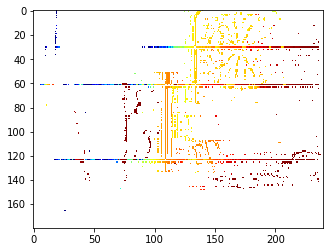

In [68]:
%matplotlib inline
plt.imshow(dsi_m, cmap="jet_r", interpolation="none")

In [69]:
bxs = np.array(bxs)

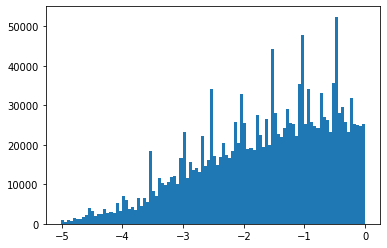

In [70]:
plt.hist(bxs, 100);